# Bangla Cyberbullying Binary Classification with Random Forest

This notebook implements a random forest classifier for binary classification of Bangla cyberbullying text (bullying vs. non-bullying).

In [64]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize
from sklearn.discriminant_analysis import StandardScaler
from bnlp import SentencepieceTokenizer
from bnlp.embedding.fasttext import BengaliFasttext
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
import torch
import os
from transformers import AutoTokenizer, AutoModel

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

In [2]:
MY_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(MY_DEVICE)

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "caching_allocator"

## 1. Loading and Exploring Datasets

In [4]:
# 1. Load the datasets
print("Loading datasets...")
original_cleaned_df = pd.read_csv("../../dataset/cleaned/original_cleaned.csv")
only_augmented_cleaned_df = pd.read_csv("../../dataset/cleaned/only_augmented.csv")

print(f"Original dataset shape: {original_cleaned_df.shape}")
print(f"Augmented dataset shape: {only_augmented_cleaned_df.shape}")

Loading datasets...
Original dataset shape: (41907, 6)
Augmented dataset shape: (6081, 3)


In [5]:
# Display the first few rows of original dataset
original_cleaned_df.head()

,comment,Category,Gender,comment react number,label,text_length
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,Actor,Female,1.0,sexual,128
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,Singer,Male,2.0,not bully,30
2,অরে বাবা টা পাগল,Actor,Female,2.0,not bully,16
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,21
4,পটকা মাছ,Politician,Male,0.0,troll,8


## 2. Label Mapping and Visualization

In [6]:
# Map the labels for binary classification (0 for 'not bully', 1 for all other classes)
def binary_label_mapping(label):
    return 0 if label == "not bully" else 1

original_cleaned_df["label_encoded"] = original_cleaned_df["label"].apply(binary_label_mapping)
only_augmented_cleaned_df["label_encoded"] = only_augmented_cleaned_df["label"].apply(binary_label_mapping)

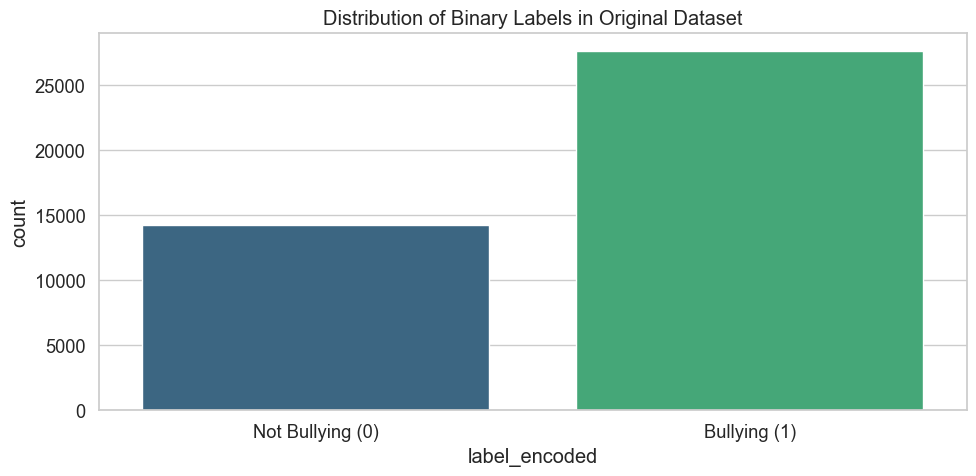

In [7]:
# Check the distribution of binary labels
plt.figure(figsize=(10, 5))
sns.countplot(x="label_encoded", data=original_cleaned_df, palette="viridis")
plt.title("Distribution of Binary Labels in Original Dataset")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.tight_layout()
plt.show()

## 3. Data Splitting and Augmentation

In [8]:
# Split the original dataset into train and test sets
X = original_cleaned_df["comment"]
y = original_cleaned_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size before augmentation: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size before augmentation: 33525
Test set size: 8382


In [9]:
# Add augmented data to the training set
X_aug = only_augmented_cleaned_df["text"]
y_aug = only_augmented_cleaned_df["label_encoded"]

# Concatenate original training data with augmented data
X_train_augmented = pd.concat([X_train, X_aug])
y_train_augmented = pd.concat([y_train, y_aug])

print(f"Training set size after augmentation: {len(X_train_augmented)}")

Training set size after augmentation: 39606


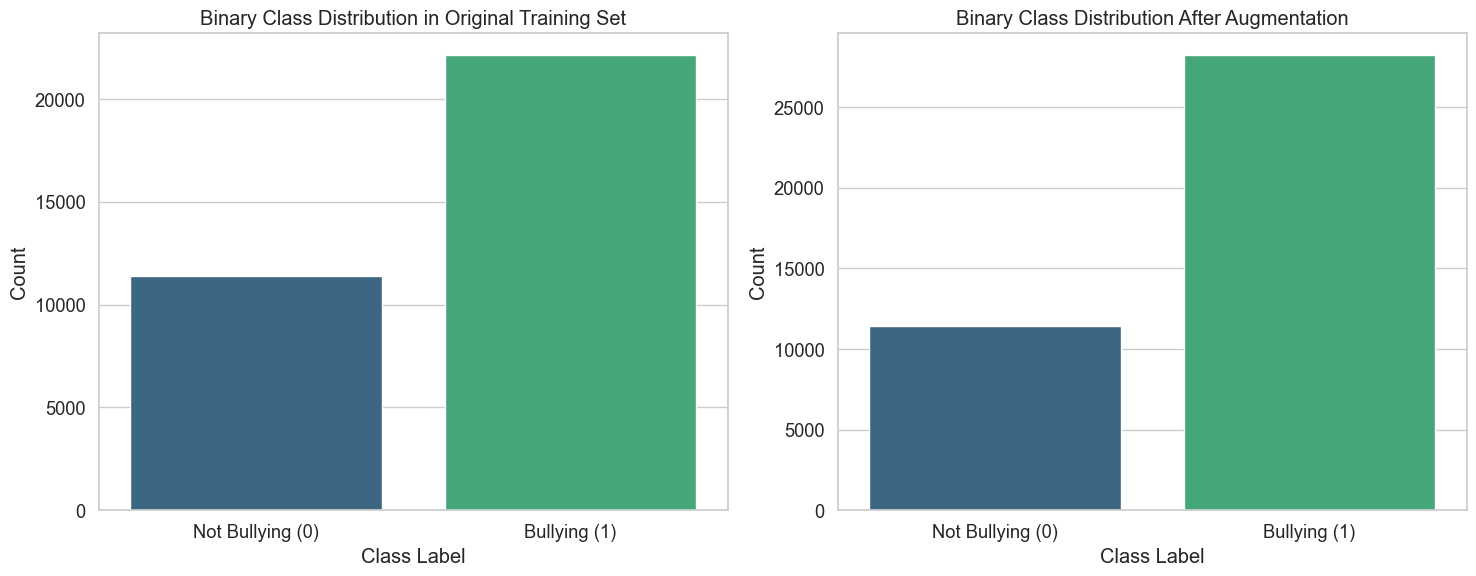

In [10]:
# Visualize the binary class distribution before and after augmentation
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette="viridis")
plt.title("Binary Class Distribution in Original Training Set")
plt.xlabel("Class Label")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_augmented, palette="viridis")
plt.title("Binary Class Distribution After Augmentation")
plt.xlabel("Class Label")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 4. Text Tokenization and Vectorization

In [11]:
bangla_bert_tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

In [12]:
bangla_bert_model = AutoModel.from_pretrained("sagorsarker/bangla-bert-base")

In [36]:
def fit_and_return_hidden_layer(input_text_array: np.ndarray):
    """
    Fit the input array to the Bengali BERT model and return the hidden layer representation
    """
    torch.cuda.empty_cache()
    tokenized_input = bangla_bert_tokenizer(
        input_text_array.tolist(),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=100,
    )

    # Move the tokenized input to GPU
    tokenized_input = {k: v.to(MY_DEVICE) for k, v in tokenized_input.items()}

    # Put model in eval mode and move to GPU if not already there
    bangla_bert_model.eval()
    bangla_bert_model.to(MY_DEVICE)

    # Process in batches to avoid memory issues
    batch_size = 32
    num_samples = tokenized_input["input_ids"].shape[0]
    all_hidden_layers = []

    with torch.no_grad():  # Don't compute gradients for inference
        for i in range(0, num_samples, batch_size):
            batch_input = {k: v[i : i + batch_size] for k, v in tokenized_input.items()}

            with torch.amp.autocast(device_type="cuda"):
                outputs = bangla_bert_model(**batch_input)
                hidden_layer = outputs.pooler_output

            # Move to CPU and detach from computation graph
            hidden_layer_cpu = hidden_layer.detach().cpu()
            reshaped_hidden_layer = hidden_layer_cpu.reshape(
                hidden_layer_cpu.shape[0], -1
            )
            all_hidden_layers.append(reshaped_hidden_layer)

    # Concatenate all batches
    combined_hidden_layers = torch.cat(all_hidden_layers, dim=0)

    return combined_hidden_layers.numpy()

In [37]:
# Apply tokenization and vectorization to training data
print("Vectorizing training data...")
start_time = time.time()
X_train_vectors = fit_and_return_hidden_layer(X_train_augmented.values)
print(
    f"Training data vectorization completed in {time.time() - start_time:.2f} seconds"
)
print(f"Training data shape: {X_train_vectors.shape}")

Vectorizing training data...
Training data vectorization completed in 72.34 seconds
Training data shape: (39606, 768)


In [39]:
# Apply tokenization and vectorization to testing data
print("Vectorizing testing data...")
start_time = time.time()
X_test_vectors = fit_and_return_hidden_layer(X_test.values)
print(f"Testing data vectorization completed in {time.time() - start_time:.2f} seconds")

Vectorizing testing data...
Testing data vectorization completed in 16.09 seconds


In [66]:
# For runing without PCA
# X_train_pca = X_train_vectors
# X_test_pca = X_test_vectors

# Dimensionality reduction to visualize the features


scaler = StandardScaler()

print("Performing dimensionality reduction...")
start_time = time.time()

# First use PCA to reduce to 50 dimensions (makes t-SNE faster)
print("Applying PCA...")
pca = PCA(n_components=0.95, random_state=42)  # Keep 95% of variance
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_vectors))
X_test_pca = pca.transform(scaler.transform(X_test_vectors))
print(f"PCA completed in {time.time() - start_time:.2f} seconds")

# Then apply t-SNE on the PCA results
# print("Applying t-SNE...")
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1)
# X_train_tsne = tsne.fit_transform(X_train_pca)
# print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")

# # Visualize the 2D projection
# plt.figure(figsize=(12, 10))
# scatter = plt.scatter(
#     X_train_tsne[:, 0],
#     X_train_tsne[:, 1],
#     c=y_train_augmented,
#     alpha=0.5,
#     cmap="viridis",
# )
# plt.colorbar(scatter, label="Class")
# plt.title("t-SNE Visualization of BERT Embeddings")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.tight_layout()
# plt.show()

Performing dimensionality reduction...
Applying PCA...
PCA completed in 1.64 seconds


## 5. Training Random Forest Model

In [67]:
# Configure and train Random Forest classifier
print("Training Random Forest model...")
# Parameters optimized for text embeddings
rf_model = RandomForestClassifier(
    n_estimators=200,  # More trees for better performance
    max_depth=None,    # Allow trees to grow fully
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="sqrt",  # Common choice for high-dimensional data
    bootstrap=True,
    class_weight="balanced",  # Handle class imbalance
    random_state=42,
    n_jobs=-1,  # Use all processors
)

start_time = time.time()
rf_model.fit(X_train_pca, y_train_augmented)
training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

Training Random Forest model...
Model trained in 18.50 seconds


## 6. Model Evaluation - Basic Metrics

In [68]:
# Make predictions and calculate basic metrics
print("Evaluating model...")
y_pred = rf_model.predict(X_test_pca)

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model...
Accuracy: 0.7521
Precision: 0.7829
Recall: 0.7521
F1 Score: 0.7114


In [71]:
# Display classification report for binary classification
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Bullying", "Bullying"]))

Classification Report:
              precision    recall  f1-score   support

Not Bullying       0.88      0.32      0.46      2852
    Bullying       0.73      0.98      0.84      5530

    accuracy                           0.75      8382
   macro avg       0.81      0.65      0.65      8382
weighted avg       0.78      0.75      0.71      8382



## 7. Confusion Matrix Visualization

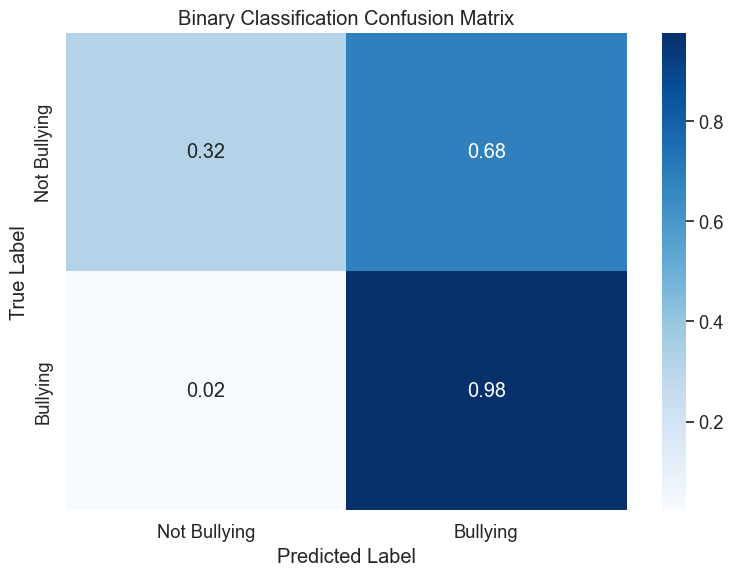

In [74]:
# Create and display confusion matrix for binary classification
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["Not Bullying", "Bullying"],
    yticklabels=["Not Bullying", "Bullying"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Binary Classification Confusion Matrix")
plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

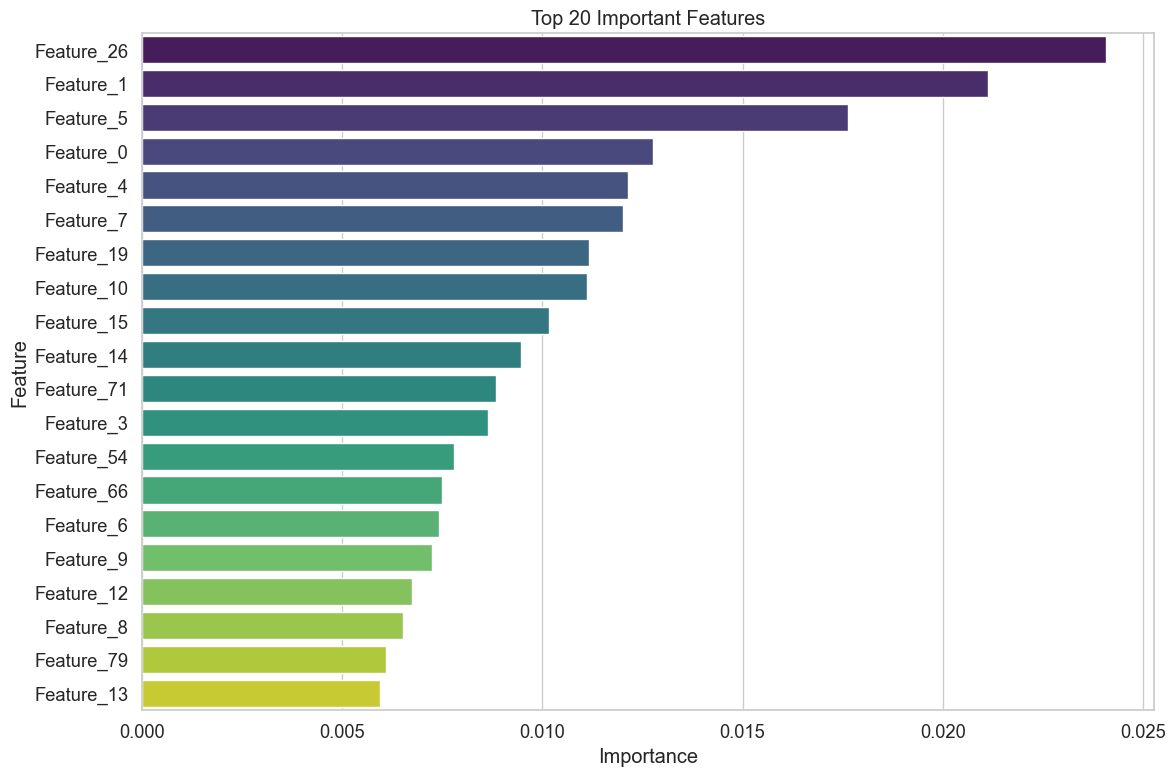

In [75]:
# Analyze feature importance
feature_importance = pd.DataFrame(
    {
        "Feature": [f"Feature_{i}" for i in range(X_train_pca.shape[1])],
        "Importance": rf_model.feature_importances_,
    }
)
feature_importance = feature_importance.sort_values("Importance", ascending=False).head(
    20
)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()

## 9. ROC Curve Analysis

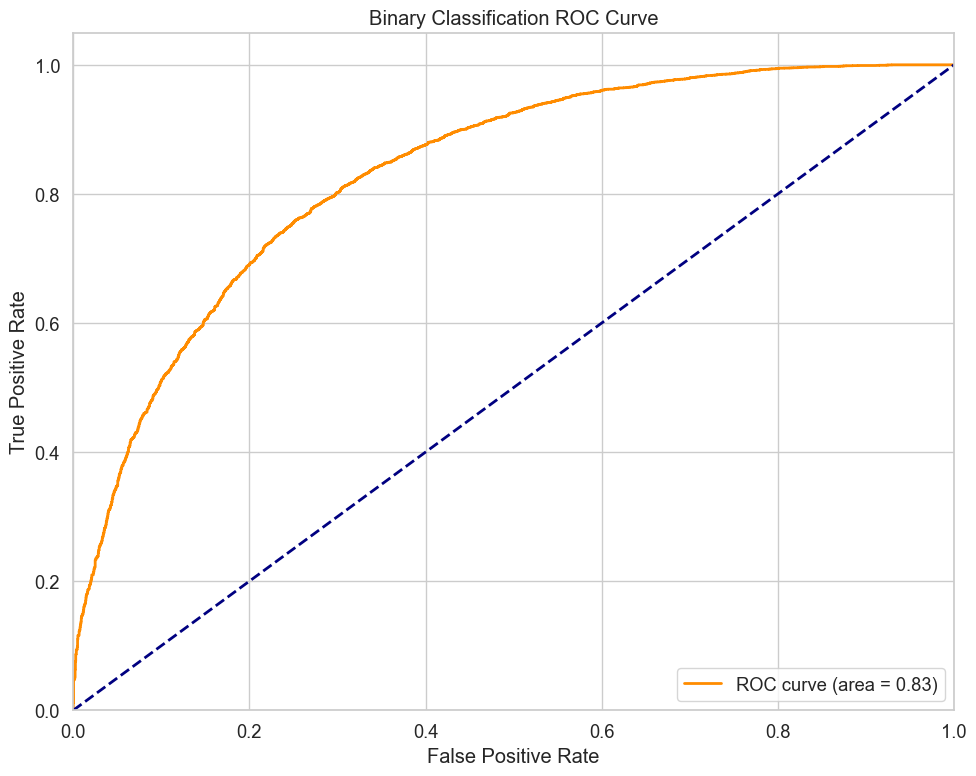

In [76]:
# ROC Curve and AUC for binary classification
y_score = rf_model.predict_proba(X_test_pca)[:, 1]  # Probability of positive class

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Classification ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 10. Precision-Recall Curve Analysis

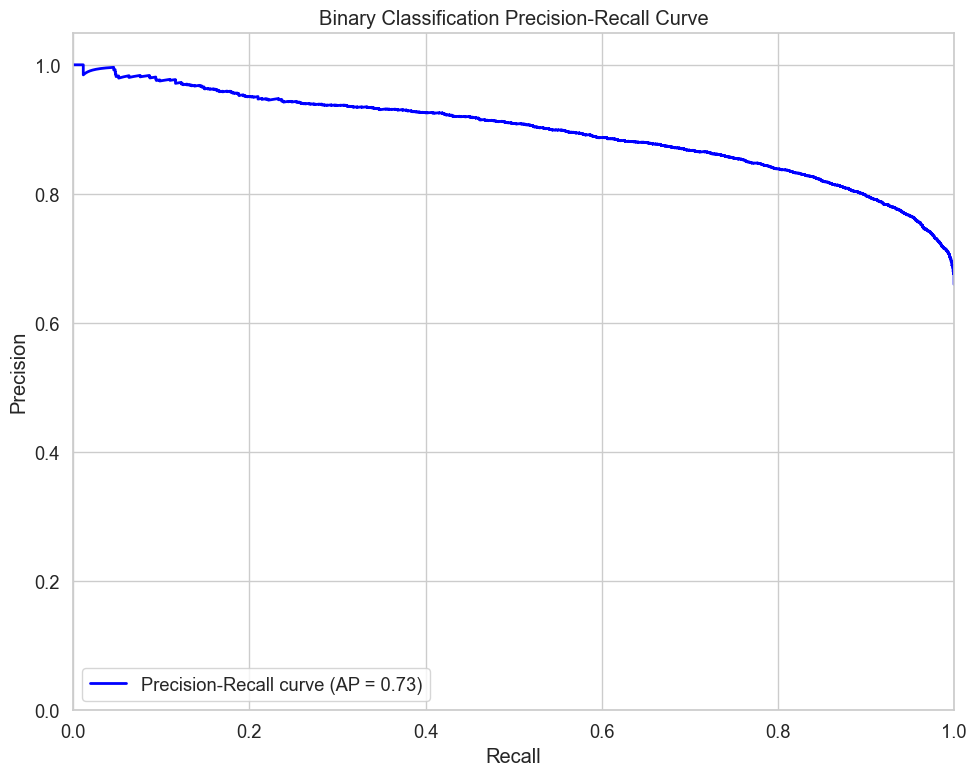

In [77]:
# Calculate Precision-Recall curve for binary classification
precision, recall, _ = precision_recall_curve(y_test, y_score)
avg_precision = precision_score(y_test, y_pred)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Classification Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 12. Model Summary and Saving

In [78]:
# Summary of the binary classification model
print("Binary Classification Model Summary:")
print(f"Total samples in training set (with augmentation): {len(X_train_augmented)}")
print(f"Total samples in test set: {len(X_test)}")
print(f"Number of features (vector dimension): {X_train_vectors.shape[1]}")
print(f"Final model accuracy on test set: {accuracy:.4f}")
plt.show()

Binary Classification Model Summary:
Total samples in training set (with augmentation): 39606
Total samples in test set: 8382
Number of features (vector dimension): 768
Final model accuracy on test set: 0.7521


In [79]:
# Save the model if needed
import joblib

joblib.dump(rf_model, "../../models/bangla_bert/binary_bangla_bert_tuned_rf.pkl")

['../../models/bangla_bert/binary_bangla_bert_tuned_rf.pkl']